# How Netflix Recommends Movies to You
* Data: https://grouplens.org/datasets/movielens/
* Original Article Code: https://jamesrledoux.com/algorithms/offline-bandit-evaluation/

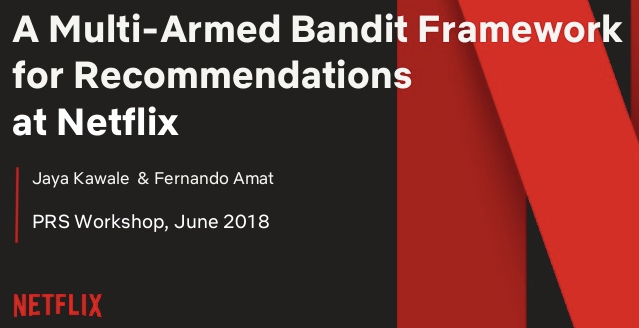

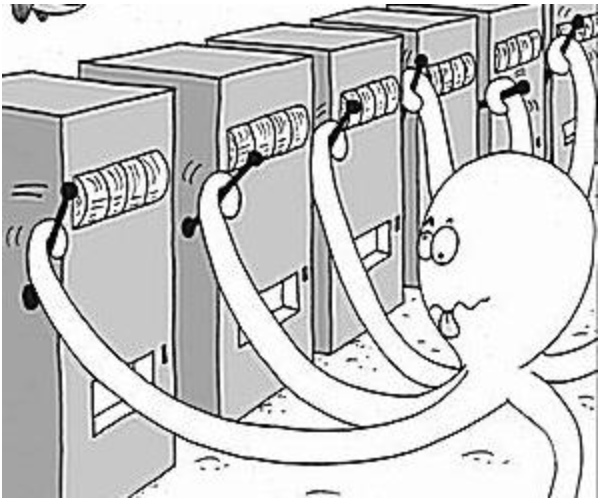

In [1]:
import pandas as pd
import numpy as np
from time import time

In [2]:
t1 = time()
def read_movielens_25m():
    ratings = pd.read_csv('ratings.csv', engine='python')
    movies = pd.read_csv('movies.csv', engine='python')
    movies = movies.join(movies.genres.str.get_dummies().astype(bool))
    movies.drop('genres', inplace=True, axis=1)
    df = ratings.join(movies, on='movieId', how='left', rsuffix='_movie')
    return df

def preprocess_movielens_25m(df, min_number_of_reviews=20000):
    # remove ratings of movies with < N ratings. too few ratings will cause the recsys to get stuck in offline evaluation
    movies_to_keep = pd.DataFrame(df.movieId.value_counts())\
        .loc[pd.DataFrame(df.movieId.value_counts())['movieId']>=min_number_of_reviews].index
    df = df.loc[df['movieId'].isin(movies_to_keep)]
    # shuffle rows to debias order of user ids
    df = df.sample(frac=1)
    # create a 't' column to represent time steps for the bandit to simulate a live learning scenario
    df['t'] = np.arange(len(df))
    df.index = df['t']
    # rating >= 4.5 stars is a 'like', < 4 stars is a 'dislike'
    df['liked'] = df['rating'].apply(lambda x: 1 if x >= 4.5 else 0)
    return df

def get_ratings_25m(min_number_of_reviews=20000):
    df = read_movielens_25m()
    df = preprocess_movielens_25m(df, min_number_of_reviews=min_number_of_reviews)
    return df

df_ = get_ratings_25m()
df_ = df_[['timestamp', 'movieId', 'userId', 'liked']]
print(df_.shape)
display(df_.head())
print('took ', round(time()-t1, 2), ' seconds')

(6589715, 4)


,timestamp,movieId,userId,liked
t,,,,
0,1070796391,539,139342,1
1,1156565087,539,60228,1
2,962834713,2858,63497,1
3,1117314307,5618,11816,1
4,1291522766,1580,31178,0


took  192.87  seconds


In [3]:
df = df_.copy()

# Netflix Replay Evaluation
I.E. How does Netflix actually test offline if this algo would work before they put it into production?

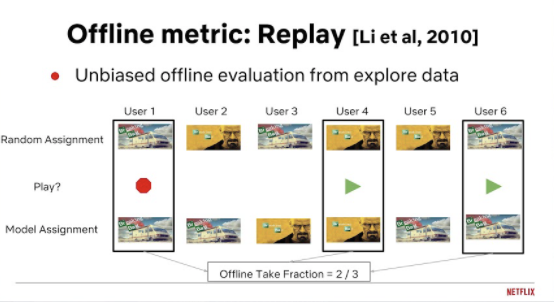

In [4]:
def replay_score(history, df, t, batch_size, recs):
    """
    https://arxiv.org/pdf/1003.5956.pdf
    replay score. reward if rec matches logged data, ignore otherwise.
    I.E. If MAB recommended 5 movies & historical viewer data showed they watched 3 of the 5 then we'd
    only pull the rewards for the 3 movies they played; [1, 0, 1] = liked, disliked, liked for example.
    """
    # reward if rec matches logged data, ignore otherwise
    actions = df[t:t+batch_size] # 100 possible movie matches at once
    # Core of "Reply": Matching our bandit policy recommendations with actual viewer content at current timestep
    actions = actions.loc[actions['movieId'].isin(recs)] # Number out of 100 movies that matched
    actions['scoring_round'] = t
    # add row to history if recs match logging policy
    history = history.append(actions) # cumulatively grows as algo steps through time
    action_liked = actions[['movieId', 'liked']]
    return history, action_liked

### Run Random Policy

In [5]:
TIMESTAMP = 't'
ARM = 'movieId'
ID = 'userId'
REWARD = 'liked'

NUM_RECS_AT_ONCE = 5 # ACTION: number of processors to show at once; NFLX shows 5 at once, for example.
BATCH_SIZE = 100 # STEP: number of values to step through at a time (note that 1 step at a time isn't efficient)

# initialize empty history for random policy
# (the algorithm should be able to see all events and outcomes prior to the current timestep, but no current or future outcomes)
history = pd.DataFrame(data=None, columns=df.columns)

print("Running Algorithm...")

# initialize empty list for storing scores from each step
random_rewards = []

for t in range(df.shape[0]//BATCH_SIZE):
    t = t * BATCH_SIZE
#     POLICY: generate recommendations from a random policy
    recs = np.random.choice(df[ARM].unique(), size=NUM_RECS_AT_ONCE, replace=False)

#     print(recs) # Number of processors by ID
    # send recommendations and dataset to a scoring function so the model can learn & adjust its policy in the next iteration
    history, action_score = replay_score(history, df, t, BATCH_SIZE, recs)
#     print(f"Current history: \n {history} \n")
#     print(f"Current action: \n {action_score} \n")
    
    if action_score is not None:
        action_score = action_score[REWARD].tolist() # REWARD Pulls out 1 or 0, reward or not
        random_rewards.extend(action_score)
#         print(f"Cumulative Rewards at time t = {t}: \n {rewards} \n")  


# Plot to see what happened.
random_cumulative_rewards = np.cumsum(random_rewards)
print(random_cumulative_rewards)
random_trailing_ctr = np.asarray(pd.Series(random_rewards).rolling(50).mean())
print(random_trailing_ctr)

Running Algorithm...
[    0     1     1 ... 54103 54103 54103]
[ nan  nan  nan ... 0.42 0.42 0.42]


### Run Epsilon Greedy Policy

In [7]:
# How often should we explore a new arm?
EPSILON = 0.10
NUM_RECS_AT_ONCE = 5 # ACTION: number of processors to show at once; NFLX shows 5 at once, for example.
BATCH_SIZE = 100 # STEP: number of values to step through at a time (note that 1 step at a time isn't efficient)

def epsilon_greedy_policy(df, arms, epsilon, slate_size, batch_size):
    '''
    df: dataset to apply the policy to
    epsilon: float. represents the % of timesteps where we explore random arms
    slate_size: int. the number of recommendations to make at each step.
    batch_size: int. the number of users to serve these recommendations to before updating the bandit's policy.
    '''
    # draw a 0 or 1 from a binomial distribution, with epsilon% likelihood of drawing a 1
    explore = np.random.binomial(1, epsilon)
    # if explore: shuffle movies to choose a random set of recommendations
    if explore == 1 or df.shape[0]==0:
        recs = np.random.choice(arms, size=(slate_size), replace=False)
    # if exploit: sort movies by "like rate", recommend movies with the best performance so far
    else:
        scores = df[[ARM, REWARD]].groupby(ARM).agg({REWARD: ['mean', 'count']})
        scores.columns = ['mean', 'count']
        scores[ARM] = scores.index
        scores = scores.sort_values('mean', ascending=False)
        recs = scores.loc[scores.index[0:slate_size], ARM].values
    return recs


# initialize empty history 
# (offline eval means you can only add to history when rec matches historic data)
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({ARM: 'int32', REWARD: 'float'})

# to speed this up, retrain the bandit every batch_size time steps
# this lets us measure batch_size actions against a slate of recommendations rather than generating
#      recs at each time step. this seems like the only way to make it through a large dataset like
#      this and get a meaningful sample size with offline/replay evaluation
print("Running Algorithm...")
ep_rewards = []
max_time = df.shape[0] # total number of ratings to evaluate using the bandit
for t in range(max_time//BATCH_SIZE): #df.t:
    t = t * BATCH_SIZE
    # choose which arm to pull
    recs = epsilon_greedy_policy(df=history.loc[history.index<=t,], arms=df[ARM].unique(),
                                 epsilon=EPSILON, slate_size=NUM_RECS_AT_ONCE, batch_size=BATCH_SIZE)
    history, action_score = replay_score(history, df, t, BATCH_SIZE, recs)
    if action_score is not None:
        action_score = action_score[REWARD].tolist()
        ep_rewards.extend(action_score)
        
ep_cumulative_rewards = np.cumsum(ep_rewards)
print(ep_cumulative_rewards)
ep_trailing_ctr = np.asarray(pd.Series(ep_rewards).rolling(50).mean())
print(ep_trailing_ctr)

Running Algorithm...
[     0      0      0 ... 140210 140211 140211]
[ nan  nan  nan ... 0.56 0.58 0.56]


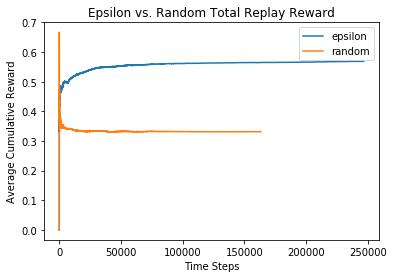

In [20]:
# plt.plot(pd.Series(random_rewards).rolling(200).mean(), label='random')
# plt.plot(pd.Series(ep_rewards).rolling(200).mean(), label='epsilon')
plt.plot(ep_cumulative_avg, label='epsilon')
plt.plot(random_cumulative_avg, label='random')
plt.title("Epsilon vs. Random Total Replay Reward")
plt.xlabel("Time Steps")
plt.ylabel("Average Cumulative Reward")
plt.legend()
plt.show()